# Estimate the liquidity factor from T-bill yields

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

Load the Svensson curve coefficients

In [2]:
df = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Gurkaynak, Sack, Wright. 2006. The U.S. Treasury Yield Curve 1961 to the Present/svensson_coefs.dta')

df.index = pd.PeriodIndex(df['date'], freq='D')

del df['date']

df = df.resample('M').last()
df.head()

,beta0,beta1,beta2,beta3,tau1,tau2
date,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999


Compute zero-coupon yield curve for 3-month maturity

In [3]:
n = 3/12

df['term1'] = (1 - np.exp(-n/df['tau1'])) / (n/df['tau1'])
df['term2'] = df['term1'] - np.exp(-n/df['tau1'])
df['term3'] = (1 - np.exp(-n/df['tau2'])) / (n/df['tau2']) - np.exp(-n/df['tau2'])

df['sven_m3'] = df['beta0'] + df['beta1'] * df['term1'] + df['beta2'] * df['term2'] + df['beta3'] * df['term3']

del df['term1']
del df['term2']
del df['term3']
            
df.head(5)

,beta0,beta1,beta2,beta3,tau1,tau2,sven_3m
date,,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999,2.666255
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999,2.279885
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999,2.734870
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999,2.492253
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999,2.503662


Compare to the zero-coupon yield datafile to confirm that the formula is right

In [4]:
# df_compare = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Gurkaynak, Sack, Wright. 2006. The U.S. Treasury Yield Curve 1961 to the Present/zero_coupon_yields_monthly_end.dta')

# df_compare.index = pd.PeriodIndex(df_compare['date'], freq='M')

# combined = pd.concat([df, df_compare], axis=1)

# combined[['yield1', 'sveny01']].corr()

Combine with 3-month yields from FRED

In [5]:
df_3m = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/Treasury Bills/yield_tbills_monthly_end.dta')

df_3m.index = pd.PeriodIndex(df_3m['date'], freq='M')

del df_3m['date']

df = df.join(df_3m['m3'])

df.head()

,beta0,beta1,beta2,beta3,tau1,tau2,sven_3m,m3
date,,,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999,2.666255,2.27
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999,2.279885,2.26
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999,2.734870,2.35
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999,2.492253,2.23
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999,2.503662,2.28


Create the liquidity factor as the deviation of 3m T-bill yields from the Svensson curve

In [6]:
df['liq'] = df['m3'] - df['sven_m3']

df.head()

,beta0,beta1,beta2,beta3,tau1,tau2,sven_3m,m3,liq
date,,,,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999,2.666255,2.27,0.396255
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999,2.279885,2.26,0.019885
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999,2.734870,2.35,0.384870
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999,2.492253,2.23,0.262253
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999,2.503662,2.28,0.223662


Combine with the excess return and Cochrane-Piazzesi factor

In [7]:
df_exrets = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from FRB/excess_returns.dta')

df_exrets.index = pd.PeriodIndex(df_exrets['date'], freq='M')

del df_exrets['date']


df_risk_premiums = pd.read_stata('/Users/dioscuroi/OneDrive - UNSW/Research Data/Bonds/Bond Yields from CRSP/risk_premium_factors.dta')

df_risk_premiums.index = pd.PeriodIndex(df_risk_premiums['date'], freq='M')

del df_risk_premiums['date']


df = df.join(df_exrets)
df = df.join(df_risk_premiums)

df.head()

,beta0,beta1,beta2,beta3,tau1,tau2,sven_3m,m3,liq,rf1m,...,exret_monthly10,exret_monthly11,exret_monthly12,exret_monthly13,exret_monthly14,exret_monthly15,pers_infl,c1,cycle,tent
date,,,,,,,,,,,,,,,,,,,,,
1961-06,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.98999,2.666255,2.27,0.396255,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009324
1961-07,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.98999,2.279885,2.26,0.019885,0.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012184
1961-08,4.241704,-1.427809,-2.124631,0.0,0.507521,-999.98999,2.734870,2.35,0.384870,0.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019313
1961-09,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.98999,2.492253,2.23,0.262253,0.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014579
1961-10,4.151372,-1.812799,0.422462,0.0,1.591745,-999.98999,2.503662,2.28,0.223662,0.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002499


Predict excess returns using the liquidity factor

In [1]:
X = sm.add_constant(df[['tent', 'liq']])

# df['exret_annual5'].shift(-12)

ols = sm.OLS(df['exret_annual5'].shift(-12), X, missing='drop')

results = ols.fit()

print(results.summary())

NameError: name 'sm' is not defined

Predict excess returns with Markov switch model

In [38]:
regime_model = sm.tsa.MarkovRegression(df['exret_annual5'].shift(-12), k_regimes=2, exog=df[['tent', 'liq']], missing='drop')

regime_results = regime_model.fit()

print(regime_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:          exret_annual5   No. Observations:                  659
Model:               MarkovRegression   Log Likelihood                1350.759
Date:                Thu, 02 Nov 2017   AIC                          -2683.518
Time:                        17:23:19   BIC                          -2643.101
Sample:                    06-30-1961   HQIC                         -2667.851
                         - 04-30-2016                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0323      0.003    -10.699      0.000      -0.038      -0.026
x1             0.8383      0.124      6.784      0.0

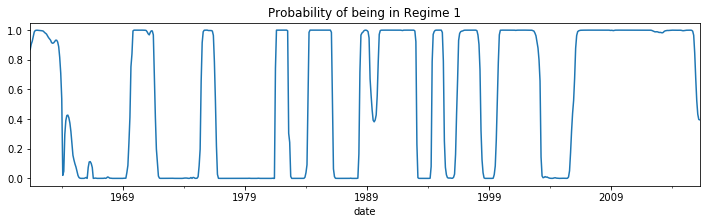

In [39]:
regime_results.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in Regime 1', figsize=(12,3));